Need to install numpy-stl:
__pip install numpy-stl__

In [985]:
import matplotlib.pyplot as plt
import numpy as np
import os
from stl import mesh
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
import sympy as sp
import pandas as pd

from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_kinematics import KDLKinematics


# Load URDF

In [3]:
import xml.etree.ElementTree as ET


def loadURDF(urdfPath):
    tree = ET.parse(urdfPath)
    root = tree.getroot()
    model = {}

    for child in root.iter('joint'):
        model[child.attrib['name']] = {}

        for at in child:
            model[child.attrib['name']][at.tag] = at.attrib
    return model
            
            
def getLegDimensions(urdf_model):
    
    
    dimentions = {}
    leg_names   = ['fl', 'fr', 'bl', 'br']
    joint_names = ['hip2', 'knee', 'feet']
    
    for name in leg_names:
        dimentions[name] = {}

    
    for keys in urdf_model:
        for joint_name in joint_names:
            
            if joint_name in keys:
                name = keys.split('_')[1]
                offset = np.array(urdf_model[keys]["origin"]["xyz"].split())
                dimentions[name][joint_name] = offset.astype(np.float)


    dimentions_leg = {}
    for key in dimentions:
        dimentions_leg[key] = np.array(  [dimentions[key][j] for j in joint_names] )

    return dimentions_leg





URDF_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/urdf/'
urdf_model     = URDF_DIR + 'pavlov_mini.urdf'

robot_model      = loadURDF(urdf_model)
leg_dimentions   = getLegDimensions(robot_model)
for key in leg_dimentions:
    print(key)
    print(leg_dimentions[key])
    print("")

bl
[[ 0.       0.042    0.     ]
 [ 0.      -0.00436 -0.11335]
 [ 0.      -0.01451 -0.10938]]

fr
[[ 0.      -0.042    0.     ]
 [ 0.       0.00436 -0.11335]
 [ 0.       0.01451 -0.10938]]

fl
[[ 0.       0.042    0.     ]
 [ 0.      -0.00436 -0.11335]
 [ 0.      -0.01451 -0.10938]]

br
[[ 0.      -0.042    0.     ]
 [ 0.       0.00436 -0.11335]
 [ 0.       0.01451 -0.10938]]



# Forward kinematics FR

Text(0.5,0.98,u'RIGHT')

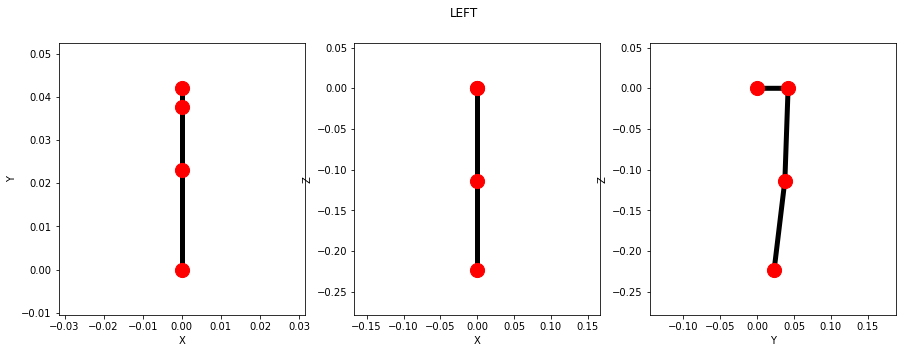

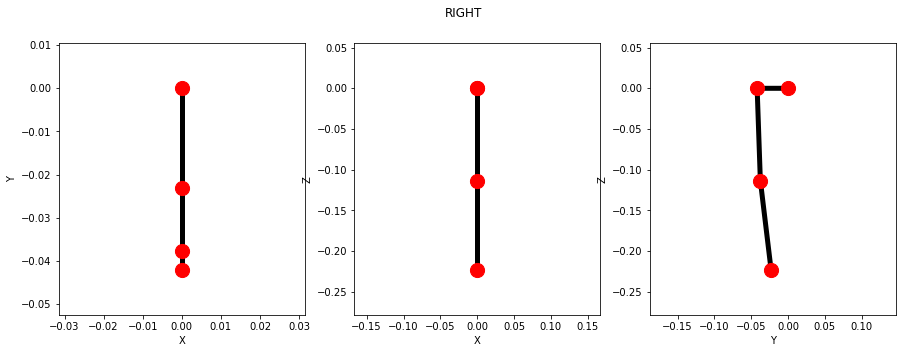

In [986]:
def plotLeg(leg_dimentions, axes, leg = 'fr', alpha = 1, range_axis_factor = 1.5):
    offsets = leg_dimentions[leg]
    

    x = [0]
    y = [0]
    z = [0]
    for i in range(3):
        if i < 1:
            x.append(offsets[i,0])
            y.append(offsets[i,1])
            z.append(offsets[i,2])
        else:
            x.append(offsets[i,0] + x[-1])
            y.append(offsets[i,1] + y[-1])
            z.append(offsets[i,2] + z[-1])


    plots = np.array([[x,y], [x,z], [y,z]])
    plots_name = [['X', 'Y'], ['X', 'Z'], ['Y', 'Z']]
    for i in range(3):
        
        axes[i].plot(plots[i][0], plots[i][1], color = 'black', linewidth = 5, alpha = alpha)
        axes[i].scatter(plots[i][0], plots[i][1], color = 'red', s = 200, zorder = 2.5, alpha = alpha)

        range_axis = [np.max(plots[i][0]) - np.min(plots[i][0]), 
                      np.max(plots[i][1]) - np.min(plots[i][1])]
        range_axis = np.max(range_axis)*range_axis_factor

        mean_val_x = ( np.max(plots[i][0]) + np.min(plots[i][0]))/2 
        mean_val_y = ( np.max(plots[i][1]) + np.min(plots[i][1]))/2 
        
        axes[i].set_xlim(-range_axis/2 + mean_val_x, range_axis/2 + mean_val_x)
        axes[i].set_ylim(-range_axis/2 + mean_val_y, range_axis/2 + mean_val_y)
        axes[i].set_xlabel(plots_name[i][0])
        axes[i].set_ylabel(plots_name[i][1])

    return np.array([x,y,z]).T
    
fig, axes = plt.subplots(1,3,figsize = (15,5))
_= plotLeg(leg_dimentions, axes, leg='fl')
plt.suptitle('LEFT')


fig, axes = plt.subplots(1,3,figsize = (15,5))
_= plotLeg(leg_dimentions, axes, leg='fr')
plt.suptitle('RIGHT')


In [995]:
urdf_str = open(urdf_model, 'r').read()
robot_urdf = URDF.from_xml_string(urdf_str)


In [994]:
print(robot_urdf.joints[0])

axis: None
calibration: None
child: hip_fl_ref
dynamics: None
limit: None
mimic: None
name: fl_ref
origin:
  rpy:
  - 0
  - 0
  - 0
  xyz:
  - 0.10136
  - 0.05355
  - 0.0
parent: base_link
safety_controller: None
type: fixed


In [993]:
print(robot_urdf.joints[0].origin.xyz)

[0.10136, 0.05355, 0.0]


In [1060]:
def getJointPositions(robot_urdf, leg, angles):
    
    hip_ref       = 'hip_{:s}_ref'   .format(leg)
    femur_link    = 'femur_{:s}_link'.format(leg)
    tibia_link    = 'tibia_{:s}_link'.format(leg)
    feet_link     = 'feet_{:s}'      .format(leg)
    
    kdl_femur = KDLKinematics(robot_urdf, hip_ref, femur_link)
    kdl_tibia = KDLKinematics(robot_urdf, hip_ref, tibia_link)
    kdl_feet  = KDLKinematics(robot_urdf, hip_ref, feet_link )
    
    pose_femur = kdl_femur.forward(angles[0:2])
    pose_tibia = kdl_tibia.forward(angles)
    pose_feet  = kdl_feet .forward(angles)

    pos_femur  = [pose_femur[0, 3], pose_femur[1, 3], pose_femur[2, 3]]
    pos_tibia  = [pose_tibia[0, 3], pose_tibia[1, 3], pose_tibia[2, 3]]
    pos_feet   = [pose_feet[0, 3],  pose_feet[1, 3],  pose_feet[2, 3]]
    
    return np.array([[0,0,0], pos_femur, pos_tibia, pos_feet])

    
    
joint_pos = getJointPositions(robot_urdf, 'fl', [0.5,0.3,0.3])


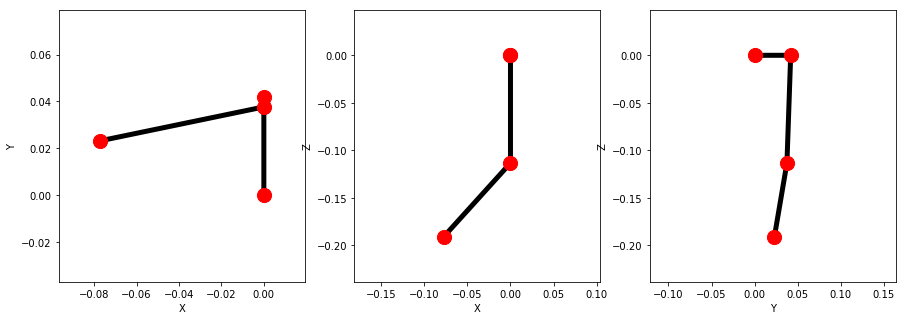

In [1072]:

def plotLegFromJointAngles(angles_deg, axes, leg = 'fl', range_axis_factor=1.5):
    angles = np.array(angles_deg)*np.pi/180
    joint_pos = getJointPositions(robot_urdf, leg, angles)

    joint0 = joint_pos[0]
    joint1 = joint_pos[1]
    joint2 = joint_pos[2]
    joint3 = joint_pos[3]


    forward_kin = np.array([joint0, joint1, joint2, joint3])


    plots = [[forward_kin[:,0], forward_kin[:,1]], 
             [forward_kin[:,0], forward_kin[:,2]], 
             [forward_kin[:,1], forward_kin[:,2]]]
    plots_name = [['X', 'Y'], ['X', 'Z'], ['Y', 'Z']]

    for i in range(3):
        axes[i].plot(plots[i][0], plots[i][1], color ='black', linewidth = 5, alpha = 1)
        axes[i].scatter(plots[i][0], plots[i][1], color ='red', s = 200, zorder = 2.5)


        axes[i].set_xlim(-0.15, 0.15)
        axes[i].set_ylim(-0.15, 0.15)


        range_axis = [np.max(plots[i][0]) - np.min(plots[i][0]), 
                      np.max(plots[i][1]) - np.min(plots[i][1])]

        range_axis = np.max(range_axis)*range_axis_factor

        mean_val_x = ( np.max(plots[i][0]) + np.min(plots[i][0]))/2 
        mean_val_y = ( np.max(plots[i][1]) + np.min(plots[i][1]))/2 

        axes[i].set_xlim(-range_axis/2 + mean_val_x, range_axis/2 + mean_val_x)
        axes[i].set_ylim(-range_axis/2 + mean_val_y, range_axis/2 + mean_val_y)
        axes[i].set_xlabel(plots_name[i][0])
        axes[i].set_ylabel(plots_name[i][1])
        
fig, axes = plt.subplots(1,3,figsize = (15,5))
plotLegFromJointAngles([0,0, 45], axes)

# Forward kinematics

Denavit-Hartenberg Notation. Based on:
https://sajidnisar.github.io/posts/python_kinematics_dh

In [5]:
fig, axes = plt.subplots(1,3,figsize = (15,5))

joint_positions = plotLeg(leg_dimentions, axes, leg='fl', alpha = 0.1)

z_axis_joints = [[-1,0,0], [0,1,0], [0,1,0],  [0,1,0]]
x_axis_joints = [[0,1,0], [0,0,-1], [0,0,-1], [0,0,-1]]

for i in range(len(z_axis_joints)):
    
    x_ax = x_axis_joints[i]
    z_ax = z_axis_joints[i]
    y_ax = np.cross(z_ax, x_ax)
    
    init_pos_axis   = joint_positions[i]
    origin_axis = [[init_pos_axis[0], init_pos_axis[1]], [init_pos_axis[0], init_pos_axis[2]], [init_pos_axis[1], init_pos_axis[2]]]
    end_axis_x  = [[x_ax[0], x_ax[1]], [x_ax[0], x_ax[2]], [x_ax[1], x_ax[2]]]
    end_axis_y  = [[y_ax[0], y_ax[1]], [y_ax[0], y_ax[2]], [y_ax[1], y_ax[2]]]
    end_axis_z  = [[z_ax[0], z_ax[1]], [z_ax[0], z_ax[2]], [z_ax[1], z_ax[2]]]

    for j in range(3):
        axes[j].quiver(origin_axis[j][0], origin_axis[j][1], end_axis_x[j][0], end_axis_x[j][1], color='red', scale=10)
        axes[j].quiver(origin_axis[j][0], origin_axis[j][1], end_axis_y[j][0], end_axis_y[j][1], color='green', scale=10)
        axes[j].quiver(origin_axis[j][0], origin_axis[j][1], end_axis_z[j][0], end_axis_z[j][1], color='blue', scale=10)

The parameters are:
 - $a_i$:      Link length. The distance along the $x$-axis from $z_{i-1}$.
 - $\alpha_i$: Twist angle. The angle between the $z_{i-1}$ axis and $z_{i}$ axis.
 - $d_i$:      Link Offset. The distance along the $z_{i-1}$ axis from the $x_i$ axis to the $x_{i+1}$ axis.
 - $\theta_i$: Joint angle. The angle between the $x_{i-1}$ axis and the $x_i$ axis about the $z_{i-1}$ axis.

In [6]:
leg_dimentions['fl']

theta2_offset = np.arctan2(leg_dimentions['fl'][1,1], leg_dimentions['fl'][1,2])

print(theta2_offset)

-3.103146675414946


In [7]:
from sympy.physics.mechanics import dynamicsymbols

theta1, theta2, l1, l2, theta, alpha, a, d = dynamicsymbols('theta1 theta2 l1 l2 theta alpha a d')
theta1, theta2, l1, l2, theta, alpha, a, d 

(theta1(t), theta2(t), l1(t), l2(t), theta(t), alpha(t), a(t), d(t))

In [8]:
rot = sp.Matrix([[sp.cos(theta), -sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha)],
                 [sp.sin(theta), sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha)],
                 [0, sp.sin(alpha), sp.cos(alpha)]])

trans = sp.Matrix([a*sp.cos(theta),a*sp.sin(theta),d])

last_row = sp.Matrix([[0, 0, 0, 1]])

m = sp.Matrix.vstack(sp.Matrix.hstack(rot, trans), last_row)
m

Matrix([
[cos(theta(t)), -sin(theta(t))*cos(alpha(t)),  sin(alpha(t))*sin(theta(t)), a(t)*cos(theta(t))],
[sin(theta(t)),  cos(alpha(t))*cos(theta(t)), -sin(alpha(t))*cos(theta(t)), a(t)*sin(theta(t))],
[            0,                sin(alpha(t)),                cos(alpha(t)),               d(t)],
[            0,                            0,                            0,                  1]])

In [967]:
params_df = {}

L0 = np.linalg.norm(leg_dimentions['fl'][0])
L1 = np.linalg.norm(leg_dimentions['fl'][2])
L2 = np.linalg.norm(leg_dimentions['fl'][1])


params_df['a_i']     = [leg_dimentions['fl'][0,1], -leg_dimentions['fl'][1,2], -leg_dimentions['fl'][2,2]]
params_df['alpha_i'] = [np.pi, -np.pi/2, 0] 
params_df['d_i']     = [0, 0, 0]#-leg_dimentions['fl'][1,1], -leg_dimentions['fl'][2,1]]
params_df['theta_i'] = [0.5, np.pi/2 + 0.5, 0]

params_df = pd.DataFrame(data = params_df, index = ['0-->1', '1-->2', '2-->3'])
params_df

a_i   alpha_i  d_i   theta_i
0-->1  0.04200  3.141593    0  0.500000
1-->2  0.11335 -1.570796    0  2.070796
2-->3  0.10938  0.000000    0  0.000000

In [945]:
T01

Matrix([
[0.877582561890373, -2.93563475640567e-17,   -0.479425538604203, 0.0368584675993957],
[0.479425538604203,   5.3736433770329e-17,    0.877582561890373, 0.0201358726213765],
[                0,                  -1.0, 6.12323399573677e-17,                  0],
[                0,                     0,                    0,                  1]])

Matrix([
[                   0, -1.19945035085481e-16,                  -1.0,   0.0368584675993957],
[                -1.0,  1.07472867540658e-16, -6.58081516144271e-33,   -0.202594127378623],
[1.07472867540658e-16,                   1.0, -1.19945035085481e-16, 2.39374317873307e-17],
[                   0,                     0,                     0,                    1]])

((3, 1), (3, 1))


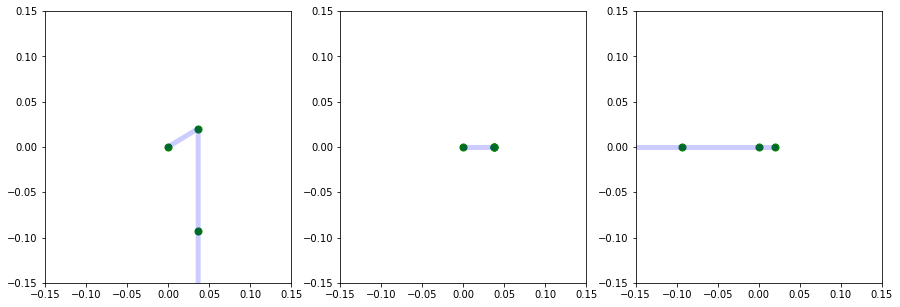

In [968]:
def getTfMatrix(node):
    rot = sp.Matrix([[sp.cos(theta), -sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha)],
                 [sp.sin(theta), sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha)],
                 [0, sp.sin(alpha), sp.cos(alpha)]])

    trans = sp.Matrix([a*sp.cos(theta),a*sp.sin(theta),d])

    last_row = sp.Matrix([[0, 0, 0, 1]])

    m = sp.Matrix.vstack(sp.Matrix.hstack(rot, trans), last_row)
    m = m.subs({alpha:params_df['alpha_i'][node], 
                a:params_df['a_i'][node], 
                theta:params_df['theta_i'][node], 
                d:params_df['d_i'][node]})
    return m

T01 = getTfMatrix(0)
T12 = getTfMatrix(1)
T23 = getTfMatrix(2)

T02 = T01*T12
T03 = T02*T23


display(T03)



fig, axes = plt.subplots(1,3,figsize= (15,5))
#joint_positions = plotLeg(leg_dimentions, axes, leg='fl', alpha = 0.1, range_axis_factor = 2.5)

joint0 = np.zeros([3,1])
joint1 = np.array(T01[:3, 3])
joint2 = np.array(T02[:3, 3])
joint3 = np.array(T03[:3, 3])

print(joint1.shape, joint0.shape)

forward_kin = np.array([joint0, joint1, joint2, joint3])


plots = [[forward_kin[:,0], forward_kin[:,1]], 
         [forward_kin[:,0], forward_kin[:,2]], 
         [forward_kin[:,1], forward_kin[:,2]]]

for i in range(3):
    axes[i].plot(plots[i][0], plots[i][1], color ='blue', linewidth = 5, alpha = 0.2)
    axes[i].scatter(plots[i][0], plots[i][1], color ='green', s = 50)

    
    axes[i].set_xlim(-0.15, 0.15)
    axes[i].set_ylim(-0.15, 0.15)



In [856]:
T12

Matrix([
[6.12323399573677e-17, -6.12323399573677e-17,                   1.0, 0],
[                 1.0,  3.74939945665464e-33, -6.12323399573677e-17, 0],
[                   0,                   1.0,  6.12323399573677e-17, 0],
[                   0,                     0,                     0, 1]])

In [857]:
T23

Matrix([
[-0.479425538604203,   5.3736433770329e-17,    0.877582561890373, -0.0201358726213765],
[-0.877582561890373, -2.93563475640566e-17,   -0.479425538604203, -0.0368584675993957],
[                 0,                  -1.0, 6.12323399573677e-17,                   0],
[                 0,                     0,                    0,                   1]])

In [418]:
T03


Matrix([
[1.23259516440783e-32,                  1.0, -2.53632656661817e-17, 2.57175827820944e-18],
[  -0.707106781186547, -1.7934537145593e-17,    -0.707106781186548,  -0.0381505536474952],
[  -0.707106781186548,  1.7934537145593e-17,     0.707106781186547,  -0.0801505536474952],
[                   0,                    0,                     0,                    1]])

In [419]:
T04

Matrix([
[1.23259516440783e-32,                  1.0, -2.53632656661817e-17, 2.57175827820944e-18],
[  -0.707106781186547, -1.7934537145593e-17,    -0.707106781186548,    -0.11549389337368],
[  -0.707106781186548,  1.7934537145593e-17,     0.707106781186547,    -0.15749389337368],
[                   0,                    0,                     0,                    1]])

In [352]:
joint_positions

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.042  ,  0.     ],
       [ 0.     ,  0.03764, -0.11335],
       [ 0.     ,  0.02313, -0.22273]])

In [142]:
joint_positions

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.042  ,  0.     ],
       [ 0.     ,  0.03764, -0.11335],
       [ 0.     ,  0.02313, -0.22273]])

In [140]:
T34 = getTfMatrix(3)
T34

Matrix([
[1, 0, 0, 0.113433822557472],
[0, 1, 0,                 0],
[0, 0, 1,          -0.01451],
[0, 0, 0,                 1]])